# **DATA ANALYSIS - PH Twitter Mis/Disinformation on Redtagging**<hr>

c

In [2]:
# Import the necessary libraries
from typing import ItemsView
import matplotlib.pyplot as plt
import pandas as pd

import tweepy, sys, re
import sched, time, datetime
import csv, openpyxl, xlsxwriter
import pprint

import numpy as np
import string, re
import itertools
import nltk
import plotly.offline as py
import plotly.graph_objs as go
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud,STOPWORDS
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from keras.preprocessing.text import Tokenizer
from keras.utils.data_utils import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM
from keras.callbacks import EarlyStopping
import keras
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
# import ipynb.fs.defs.preprocessing as prep
py.init_notebook_mode(connected=True)
%matplotlib inline


[nltk_data] Downloading package stopwords to C:\Users\Rey
[nltk_data]     Christian\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Preprocessing<hr>

Read the data

In [3]:
# Open the dataset workbook
workbook = openpyxl.load_workbook(filename = 'Text Value only Dataset - Group 32.xlsx')
worksheet = workbook['Value only']
worksheet.max_column

# Convert to a Pandas dataframe
data = worksheet.values
df = pd.DataFrame(data, columns=next(data)[0:])
df.columns

Index(['ID', 'Timestamp', 'Tweet URL', 'Group', 'Collector', 'Category',
       'Topic', 'Keywords', 'Account handle', 'Account name', 'Account bio',
       'Account type', 'Joined', 'Following', 'Followers', 'Location', 'Tweet',
       'Tweet Translated', 'Tweet Type', 'Date posted', 'Screenshot',
       'Content type', 'Replies', 'Retweets', 'Quote Tweets', 'Views',
       'Rating', 'Reasoning', 'Remarks', 'Reviewer', 'Review'],
      dtype='object')

## Data Details

Review Data Samples

In [4]:
df.head(5)

,ID,Timestamp,Tweet URL,Group,Collector,Category,Topic,Keywords,Account handle,Account name,...,Content type,Replies,Retweets,Quote Tweets,Views,Rating,Reasoning,Remarks,Reviewer,Review
0,"=TEXT(D2,""00"")&""-""&ROW(D2)-1",21/02/23 16:19:00,https://twitter.com/amylauderdake/status/13303...,32,"Aloveros, Aira Mae",REDT,Red tagging students from different universities,UP NPA PUP,@amylauderdake,amylauderdake,...,Rational,0,0,0.0,None,UNPROVEN,Accuses that the said universities are NPA bre...,Location and bio are not specified,None,None
1,"=TEXT(D3,""00"")&""-""&ROW(D3)-1",21/02/23 16:20:10,https://twitter.com/SamukaNimoUy/status/152575...,32,"Aloveros, Aira Mae",REDT,Red tagging students from UP and PUP,UP NPA PUP,@SamukaNimoUy,-Nessa-,...,Rational,0,0,0.0,None,UNPROVEN,Accuses that the said universities are NPA bre...,Location is not specified,None,None
2,"=TEXT(D4,""00"")&""-""&ROW(D4)-1",21/02/23 16:25:35,https://twitter.com/Shaider_de/status/13519219...,32,"Delos Reyes, Rey",REDT,Red tagging students from UP and PUP,UP NPA PUP,@Shaider_de,Dai Sawamura,...,Rational,0,0,0.0,None,UNPROVEN,Accuses that leaders of NPA comes from PUP and...,None,None,None
3,"=TEXT(D5,""00"")&""-""&ROW(D5)-1",21/02/23 17:23:35,https://twitter.com/n4qpu/status/1351844058935...,32,"Doros, Joshua Lloyd",REDT,Red tagging students from universities,TERORISTA UP NPA,@n4qpu,浜崎 夏海 🏅,...,Emotional,0,0,0.0,None,MISLEADING,Suggests that student activists will recruit t...,None,None,None
4,"=TEXT(D6,""00"")&""-""&ROW(D6)-1",21/02/23 17:25:35,https://twitter.com/JethroGamez/status/1293145...,32,"Doros, Joshua Lloyd",REDT,Red tagging students from UP,TERORISTA UP NPA,@JethroGamez,jethjeth ♥️💚,...,Emotional,0,0,0.0,None,UNPROVEN,Accuses UP of being controlled by the CPP-NPA-...,None,None,None


Size of Dataset 

In [5]:
df.shape

(168, 31)

The dataset has 168 tweets and 30 features.

The variable that has most null values is Account Bio, Screenshot, and Views. The columns that has null values are dropped to create `df_clean`

In [6]:
df.isnull().sum()[15:30]

Location             90
Tweet                 0
Tweet Translated      0
Tweet Type            0
Date posted           0
Screenshot          168
Content type          0
Replies               0
Retweets              0
Quote Tweets          6
Views               168
Rating                0
Reasoning             0
Remarks              68
Reviewer            168
dtype: int64

In [7]:
df_clean = df.dropna(axis=1)
(df.shape, df_clean.shape)
df_clean.columns

Index(['ID', 'Timestamp', 'Tweet URL', 'Group', 'Collector', 'Category',
       'Topic', 'Keywords', 'Account handle', 'Account name', 'Account type',
       'Joined', 'Following', 'Followers', 'Tweet', 'Tweet Translated',
       'Tweet Type', 'Date posted', 'Content type', 'Replies', 'Retweets',
       'Rating', 'Reasoning'],
      dtype='object')

The  features retained and their corresponding meaning is as follows

|Feature|Meaning|
|-|-|
|ID||
|Timestamp||
|Tweet URL||
|Group||
|Collector||
|Category||
|Topic||
|Keywords||
|Account handle||
|Account name||
|Account type||
|Joined ||
|Following||
|Followers||
|Tweet||
|Tweet Translated||
|Tweet Type||
|Data posted||
|Content type||
|Replies||
|Retweets||
|Reasong||in

Convert the column to datetime

### Tweets

In [8]:
df_Tweets = df_clean['Tweet']
df_Tweets.head(10)

0    Typical NPA UNIVERSITIES   .... Ateneo, UP. PU...
1               UP and PUP are NPA’s recruitment hubs.
2    History itself shows that Almost all CPP/NPA L...
3    Tapos ire-recruit nila yung makikita nilang po...
4    Well, I thought I'm gonna be brainwashed by th...
5                       UP terorista what do we expect
6    Ulol kiko. Tinulungan nyong makapasok ang tero...
7    Mayor oo meron tayong pandemya, pero ang kumun...
8                  Breeding ground ng terorista ang UP
9    Ano naman? Ang daming mga komunistang nirerecr...
Name: Tweet, dtype: object

The 168 tweets collected are all unique

In [9]:
df_Tweets.describe()

count                                                   168
unique                                                  168
top       Typical NPA UNIVERSITIES   .... Ateneo, UP. PU...
freq                                                      1
Name: Tweet, dtype: object

The length of each tweets in the dataset is as follows

In [10]:
df_Tweets.str.len()

0      105
1       38
2      156
3      169
4      208
      ... 
163    249
164    211
165    267
166    175
167    289
Name: Tweet, Length: 168, dtype: int64

In [11]:
tweet_len_ave = df_Tweets.str.len().sum()/df_Tweets.size
tweet_len_ave

202.375

In [25]:
df_clean['Account handle'].describe()
df.loc[df_clean['Account handle'] == "@keizerinj"]

,ID,Timestamp,Tweet URL,Group,Collector,Category,Topic,Keywords,Account handle,Account name,...,Content type,Replies,Retweets,Quote Tweets,Views,Rating,Reasoning,Remarks,Reviewer,Review
165,"=TEXT(D167,""00"")&""-""&ROW(D167)-1",24/03/23 18:43:24,https://twitter.com/keizerinj/status/154533381...,32,"Delos Reyes, Rey",REDT,Red tagging students from state universities,(UPD OR PUP OR DLSU OR Ateneo) AND (Komunista ...,@keizerinj,Yondaime,...,Emotional,0,1,0.0,None,UNPROVEN.MISLEADING,Specified that universities are being thought ...,Location and bio are not specified,None,None
166,"=TEXT(D168,""00"")&""-""&ROW(D168)-1",24/03/23 18:43:24,https://twitter.com/keizerinj/status/154533085...,32,"Delos Reyes, Rey",REDT,Red tagging students from state universities,(UPD OR PUP OR DLSU OR Ateneo) AND (Komunista ...,@keizerinj,Yondaime,...,Rational,0,0,0.0,None,UNPROVEN.MISLEADING,Specified that universities are being thought ...,Location and bio are not specified,None,None
167,"=TEXT(D169,""00"")&""-""&ROW(D169)-1",24/03/23 18:43:24,https://twitter.com/keizerinj/status/154526647...,32,"Delos Reyes, Rey",REDT,Red tagging students from state universities,(UPD OR PUP OR DLSU OR Ateneo) AND (Komunista ...,@keizerinj,Yondaime,...,Rational,0,0,0.0,None,UNPROVEN,The allegation regarding UP being infiltrated ...,Location and bio are not specified,None,None


In [13]:
df_clean.describe()

,Group,Following,Followers,Replies,Retweets
count,168.0,168.000000,1.680000e+02,168.000000,168.000000
mean,32.0,824.452381,4.358554e+04,0.041667,7.815476
std,0.0,1941.949067,3.405971e+05,0.228354,38.842942
min,32.0,1.000000,0.000000e+00,0.000000,0.000000
25%,32.0,107.000000,3.950000e+01,0.000000,0.000000
50%,32.0,368.500000,2.235000e+02,0.000000,0.000000
75%,32.0,813.000000,7.765000e+02,0.000000,1.000000
max,32.0,18364.000000,3.731281e+06,2.000000,330.000000


In [14]:
t_link = df_clean['Tweet'].str.contains('t.co/')
http_link = df_clean['Tweet'].str.contains('http.')
https_link = df_clean['Tweet'].str.contains('https.')
df_clean['Tweet'][t_link|http_link|https_link]

50     Marami talaga dyan sa UP breeding ground ng NP...
78     Much of CPP indoctrination NPA recruitment don...
79     UP, you mean the school that's funded by the g...
81     Government officials publicly hailing and hono...
83     University of Communist Party diliman QC..HEAD...
87     @boochanco Bibilhin daw ni Joma Sison ang UP a...
98     @manilabulletin Indi terorismo ang panghihikay...
100    TOTOONG MAY NPA RECRUITMENT SA MGA SCHOOL!\n\n...
101    @upsystem Dapat University of NPA na ang itawa...
108    Yan pa iskolar ng bayan?? Hahaha. tas madami N...
121    @kikopangilinan @kakiep83 If UP is a citadel o...
132    Bakit nalilinlang ng CPPNPA NDF TERRORIST ANG ...
133    Hindi daw sila KOMUNISTA pero recruiter ng mga...
135    WATCH: A day after protesting at the UP Dilima...
136    @pnagovph Sa mga estudyante ng UP, PUP atbp ga...
137    Mga komunista sa PUP basahin niyo kung bakit n...
139    May sekretong plano against the government ang...
140    Kawawa naman komunista d

Among the collected tweets, the number of tweet with link is...

In [29]:
(t_link|http_link|https_link).sum()

24

## Content type

In [65]:
df_contenttype = df_clean['Content type']
df_contenttype.head(10)

0     Rational
1     Rational
2     Rational
3    Emotional
4    Emotional
5    Emotional
6    Emotional
7    Emotional
8    Emotional
9    Emotional
Name: Content type, dtype: object

In [66]:
df_contenttype.unique()

array(['Rational', 'Emotional', 'Rational, Emotional', 'Emotionall',
       'Emotional,Rational', 'Transactional,Emotional\n'], dtype=object)

In [67]:
df_contenttype.describe()

count           168
unique            6
top       Emotional
freq            107
Name: Content type, dtype: object

In [70]:
emotional = df_contenttype.str.contains('Emotional').sum()
rational = df_contenttype.str.contains('Rational').sum()
transactional = df_contenttype.str.contains('Transactional').sum()
(emotional,rational,transactional)

(113, 59, 1)

The most common content type is `Emotional` followed by `Rational` then `Transactional`.

## Rating

In [56]:
df_contenttype = df_clean['Rating']
df_contenttype.head(10)

0      UNPROVEN
1      UNPROVEN
2      UNPROVEN
3    MISLEADING
4      UNPROVEN
5      UNPROVEN
6    MISLEADING
7      UNPROVEN
8      UNPROVEN
9      UNPROVEN
Name: Rating, dtype: object

In [61]:
df_contenttype.unique()

array(['UNPROVEN', 'MISLEADING', 'NEED CONTEXT', 'MISLEADING, UNPROVEN',
       False, 'UNPROVEN, MISLEADING', 'NEEDS CONTEXT',
       'UNPROVEN, NEEDS CONTEXT', 'UNPROVEN.MISLEADING'], dtype=object)

In [57]:
df_contenttype.describe()

count          168
unique           9
top       UNPROVEN
freq            98
Name: Rating, dtype: object

In [58]:
misleading = df_contenttype.str.contains('MISLEADING').sum()
unproven = df_contenttype.str.contains('UNPROVEN').sum()
needs_context = df_contenttype.str.contains('NEEDS CONTEXT').sum()
(misleading,unproven,needs_context)

(59, 114, 3)

The most common content type is `UNPROVEN` followed by `MISLEADING` then `NEEDS CONTEXT`.

### Dates

In [16]:
df_clean["Date posted"] = pd.to_datetime(df_clean["Date posted"])
df_clean["Date posted"]

C:\Users\REYCHR~1\AppData\Local\Temp/ipykernel_46608/2215845903.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



0     2020-11-22 11:56:00
1     2022-05-15 16:37:00
2     2021-01-20 23:58:00
3     2021-01-20 18:48:00
4     2020-08-11 19:20:00
              ...        
163   2022-07-19 14:45:33
164   2022-09-19 00:36:46
165   2022-08-16 17:02:07
166   2022-08-07 09:07:47
167   2022-08-07 08:56:00
Name: Date posted, Length: 168, dtype: datetime64[ns]

In [17]:
df_count_per_year = pd.to_datetime(df_clean['Date posted']).dt.year.value_counts()

df_count_per_year

2021    66
2022    53
2020    28
2019    14
2018     4
2017     2
2016     1
Name: Date posted, dtype: int64

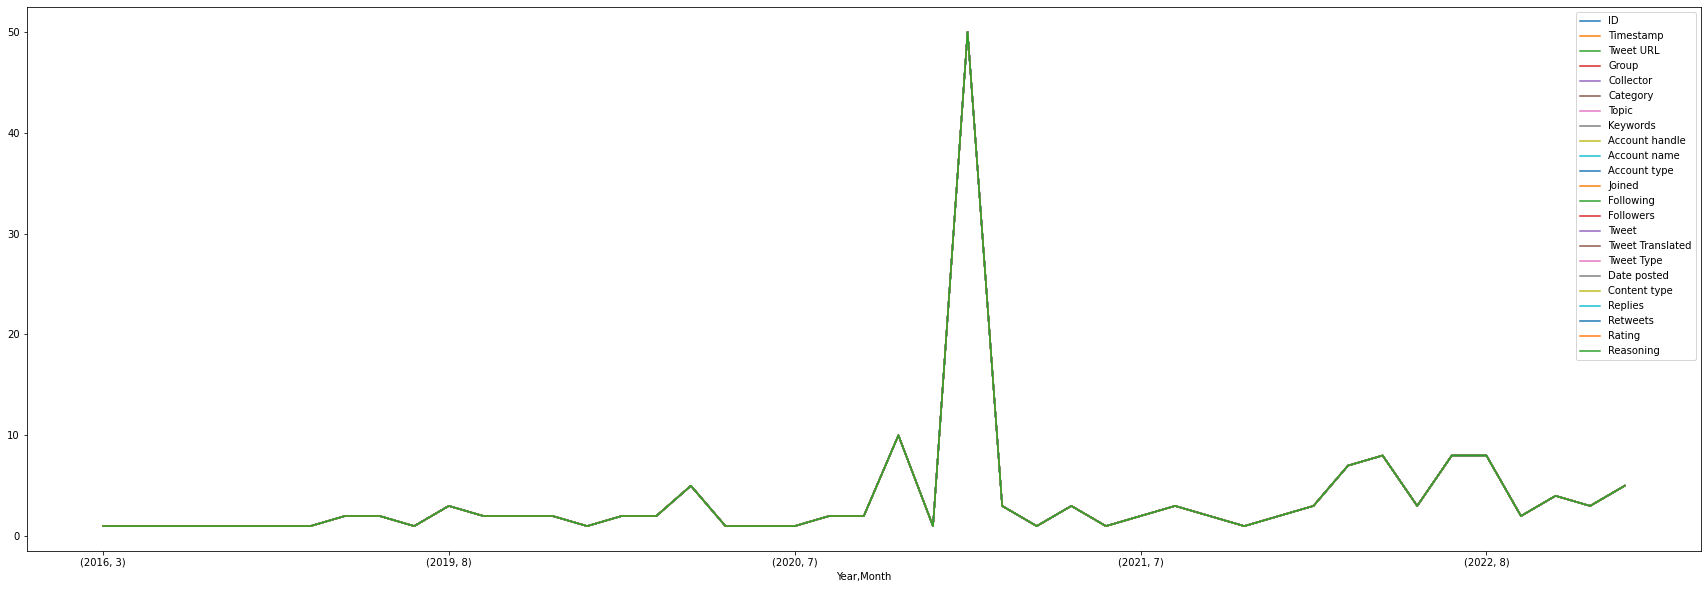

In [18]:
df_count_per_month = df_clean.groupby([df_clean['Date posted'].dt.year, df_clean['Date posted'].dt.month]).count()
df_count_per_month = df_count_per_month.rename_axis(["Year", "Month"])
# df_count_per_month = df_count_per_month["Year", "Month",  "Tweet"]
# df_count_per_month = df_count_per_month["Year", "Month"].value_counts()
# df_count_per_month = df_count_per_month.set_axis(['Year', 'Month']).Month.count()

df_count_per_month.plot(figsize=(30, 10))
plt.show()

# Visualization<hr>

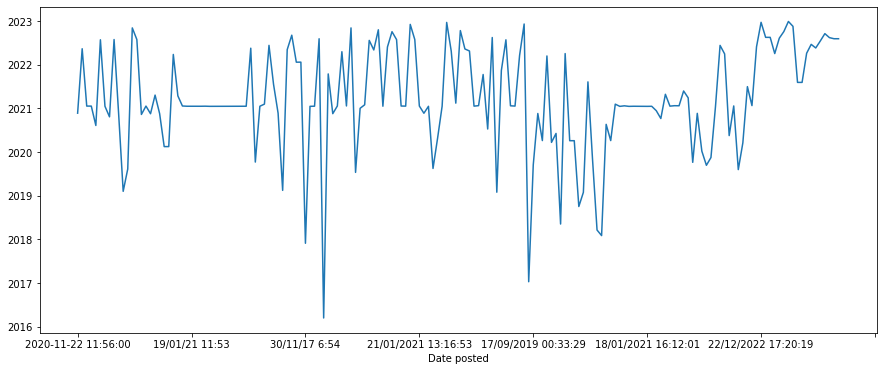

In [19]:
df_date_freq = df_clean.copy()
df_date_freq.index = df["Date posted"]
del df["Date posted"]
df_date_freq["Date posted"].plot(figsize=(15, 6))
plt.show()

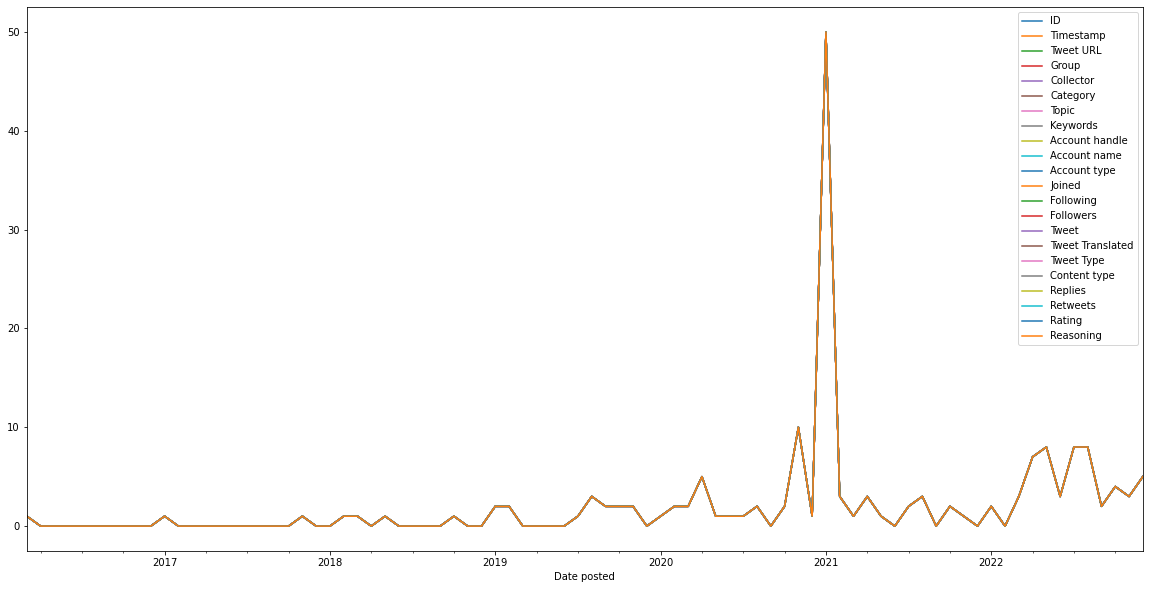

In [20]:
df_time = df_date_freq.groupby(pd.Grouper(key="Date posted", freq="1M")).count()
df_time.plot(figsize=(20, 10))
plt.show()

### Tweet Data

In [21]:
lens = df_clean['Tweet'].str.len()
(lens.mean(), lens.std(), lens.min(), lens.max())

(202.375, 77.12760151960947, 23, 335)

Distribution of tweet length:

In [22]:
data = [go.Histogram(x=lens, xbins=dict(start=0, end=8000, size=10), marker=dict(color='#8c42f4'))]
layout = go.Layout(
                  title='Length of tweets and post distribution',                  
                  xaxis=dict(title='Length'),
                  yaxis=dict(title='Count'),
                  bargap=0.1)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='length histogram')

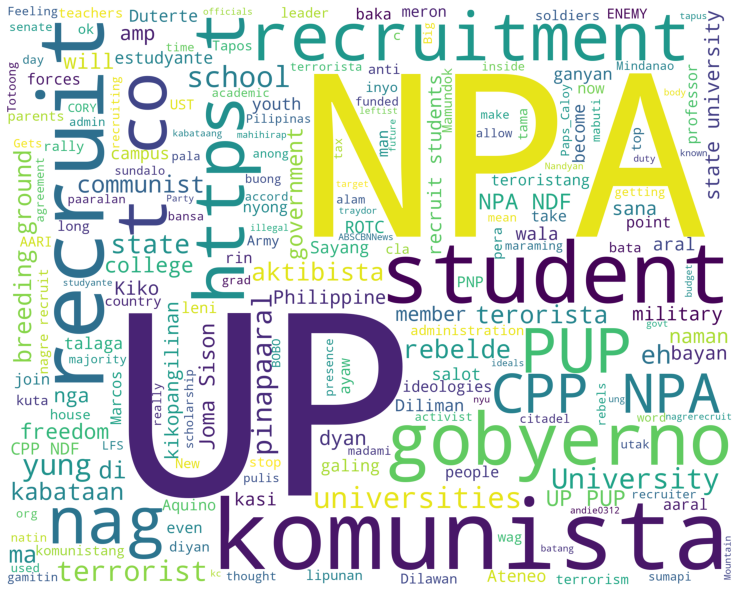

In [23]:
ENG_STOPWORDS = STOPWORDS.copy()
if 'up' in ENG_STOPWORDS:
    ENG_STOPWORDS.remove('up')
wordcloud1 = WordCloud(stopwords=list(ENG_STOPWORDS)+['at','akin',"aking","ako","alin","am","amin","aming","ang","ano","anumang","apat","atin","ating","ka","may",'sa','ang','mga','na','sa','ay','ng','ako','yun','kami','si','ni','kay','kung','yan','pa','lang','ako',"ay","bababa","bago","bakit","bawat","bilang","dahil","dalawa","dapat","din","dito","doon","gagawin","gayunman","ginagawa","ginawa","ginawang","gumawa","gusto","habang","hanggang","hindi","huwag","iba","ibaba","ibabaw","ibig","ikaw","ilagay","ilalim","ilan","inyong","isa","isang","itaas","ito","iyo","iyon","iyong","ka","kahit","kailangan","kailanman","kami","kanila","kanilang","kanino","kanya","kanyang","kapag","kapwa","karamihan","katiyakan","katulad","kaya","kaysa","ko","kong","kulang","kumuha","kung","laban","lahat","lamang","likod","lima","maaari","maaaring","maging","mahusay","makita","marami","marapat","masyado","may","mayroon","mga","minsan","mismo","mula","muli","na","nabanggit","naging","nagkaroon","nais","nakita","namin","napaka","narito","nasaan","ng","ngayon","ni","nila","nilang","nito","niya","niyang","noon","o","pa","paano","pababa","paggawa","pagitan","pagkakaroon","pagkatapos","palabas","pamamagitan","panahon","pangalawa","para","paraan","pareho","pataas","pero","pumunta","pumupunta","sa","saan","sabi","sabihin","sarili","sila","sino","siya","tatlo","tayo","tulad","tungkol","una","walang","mag","pina","mo","po","niyo","niyong","nang","nasa","pang","ninyo","nalang","taga","jan","pag","ba","dun","nyo","kayo","kayong","nagiging","re","daw","raw","dpt","s","n","u","pong","yang"],
                      background_color='white',
                      width=2500,
                      height=2000
                      ).generate(" ".join(df_clean["Tweet"].astype(str)))
plt.figure(1,figsize=(13, 13))
plt.imshow(wordcloud1)
plt.axis('off')
plt.show()

In [59]:
schools = {
        'UP':['up','university of the philippines','upd','u.p.','u.p','university of the philippines system','university of the philippines los baños','university of the philippines los banos'],
        'PUP':['pup', 'polytechnic university of the philippines'],
        'DLSU':['de la salle', 'la salle', 'dlsu', 'de la salle university'],
        'ADMU':['ateneo', 'ateneo de manila', 'ateneo de manila university'],
        'UST':['ust', 'university of santo tomas','u.s.t.','u.s.t','uste'],
        'BSU': ['batangas state university', 'bsu'],
        'NEU': ['new er university', 'neu'],
        'USC': ['university of san carlos', 'usc'],
        'ADU': ['adamson university','adu']
        
    }

school_count = {
        'UP':0,
        'PUP':0,
        'DLSU':0,
        'ADMU':0,
        'UST':0,
        'BSU':0,
        'NEU':0,
        'USC':0,
        'ADU':0
}

def get_school(tweet):
    saved_schl = []
    for school, keywords in schools.items():
        for keyword in keywords:
            if keyword in tweet.lower().split():
                saved_schl.append(school)

    saved_schl = list(set(saved_schl))
    for school in saved_schl:
        school_count[school] += 1

    return saved_schl


df_clean['school'] = df_clean['Tweet'].apply(get_school)
df_clean['school']
school_count


C:\Users\REYCHR~1\AppData\Local\Temp/ipykernel_46608/2565047370.py:40: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



{'UP': 77,
 'PUP': 17,
 'DLSU': 0,
 'ADMU': 3,
 'UST': 3,
 'BSU': 0,
 'NEU': 0,
 'USC': 0,
 'ADU': 0}